In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img_ori = cv2.imread('ISBN_rotated2.jpg',)

# converting to gray scale
img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


(<matplotlib.image.AxesImage at 0xb1abbeb148>, (-0.5, 1439.5, 1439.5, -0.5))

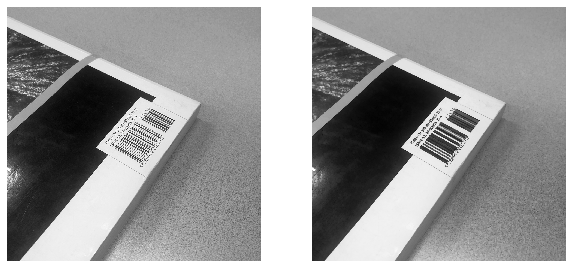

In [2]:
kernel = np.ones((5,5),np.uint8)
print(kernel)

row,col = img.shape
s_vs_p = 1 #0.5
amount = 0.01
out = np.copy(img)

# kernel = np.ones((3,3),np.uint8)        
opening = cv2.morphologyEx(out, cv2.MORPH_OPEN, kernel)
cv2.imwrite('opening.jpg', opening)

plt.figure(figsize=(10,5))
plt.subplot('121')
plt.imshow(out,cmap='gray'), plt.axis('off')
plt.subplot('122')
plt.imshow(opening,cmap='gray'), plt.axis('off')

In [7]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
from scipy.ndimage import label

In [8]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread("opening.jpg")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
#cv2.imshow("Input", image)
 
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#cv2.imshow("Thresh", thresh)

In [17]:
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
	                      labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 100))

[INFO] 79 unique segments found


In [ ]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
 
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
 
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
#show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)